Loading data...
Preprocessing data...
Metrics loaded from C:\Users\adamk\Documents\wordle_research\wordle-research\data_analysis\generated data\pickled_data.pkl
Average guesses: 3.83

Guess Distribution:
1 guesses: 401 games
2 guesses: 6896 games
3 guesses: 23035 games
4 guesses: 25578 games
5 guesses: 13205 games
6 guesses: 5944 games

Most Popular First Guesses:
stare: 4629 times
crane: 2203 times
raise: 2041 times
slate: 1479 times
adieu: 1399 times
crate: 1252 times
arise: 1216 times
audio: 1109 times
salet: 1062 times
trace: 847 times

Hard Mode vs Normal Mode:
Hard Mode Average: 3.74 (57449 games)
Normal Mode Average: 4.12 (17610 games)





100%|██████████| 75059/75059 [04:02<00:00, 309.23it/s]


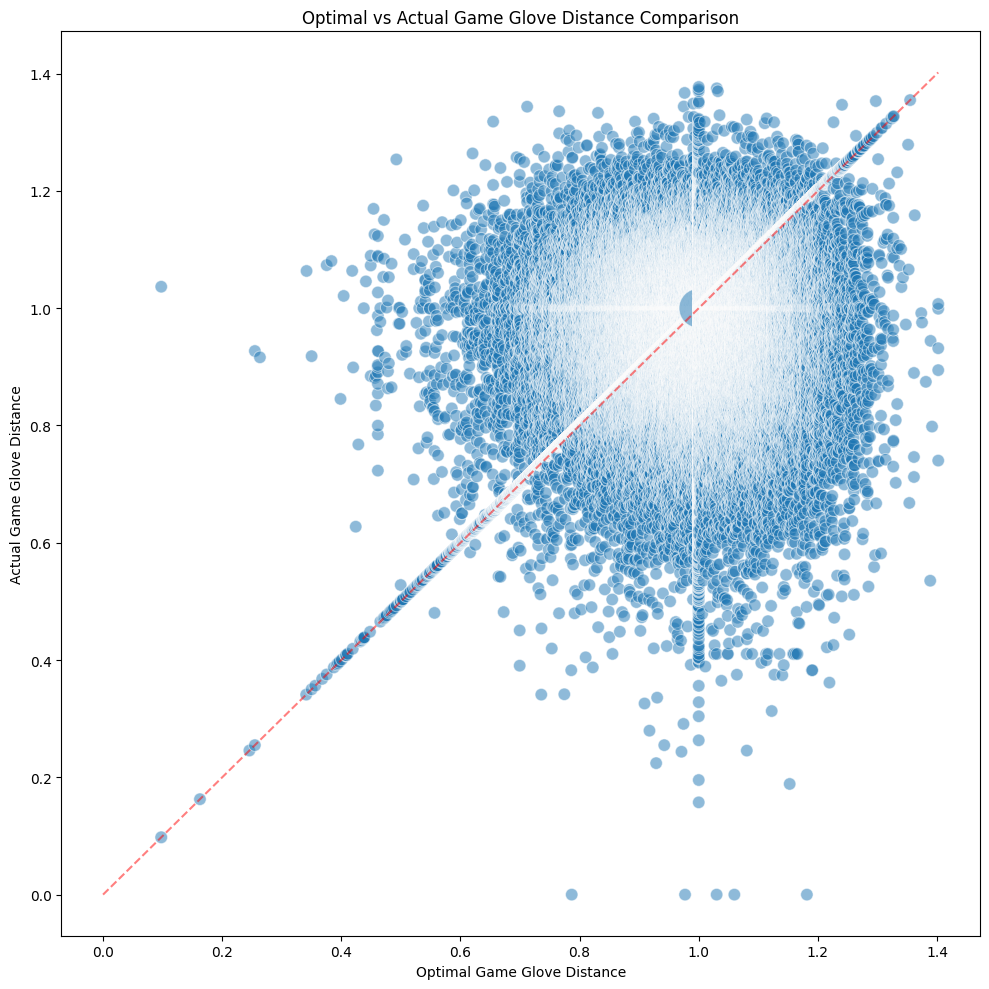

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Callable, List, Tuple, Dict, Union
from ast import literal_eval
from nltk.tokenize import SyllableTokenizer
import numpy as np
import tqdm
import gensim.downloader as api
from numpy.linalg import norm
import numpy as np
import pickle
import os
from scipy import stats

class WordleAnalyzer:
    syllable_tokenizer = SyllableTokenizer()
    glove_distance_model = api.load('glove-wiki-gigaword-300')
    MAX_GLOVE_DISTANCE = 2.0

    def __init__(self, csv_path: str, load_pickle: bool = True, pickle_name: str = "pickled_data.pkl", main_dir: str = "data_analysis/generated_data"):
        """Initialize the WordleAnalyzer with a CSV file path."""
        print("Loading data...")
        self.df = pd.read_csv(csv_path)
        print("Preprocessing data...")
        self._preprocess_data()
        self.metrics = {}
        self.main_dir = main_dir
        os.makedirs(main_dir, exist_ok=True)
        self.pickle_path = os.path.join(main_dir, pickle_name)
        
        if load_pickle and os.path.exists(self.pickle_path):
            self.load_pickled_metrics()

    def save_plot(self, plot_func: Callable[[plt.Figure], None], filename: str) -> None:
        """Save a plot as PDF in the main directory."""
        fig = plt.figure(figsize=(10, 10))
        plot_func(fig)
        pdf_path = os.path.join(self.main_dir, f"{filename}.pdf")
        plt.savefig(pdf_path, format='pdf', bbox_inches='tight')
        plt.close()
    
    def _preprocess_data(self):
        """Preprocess the data for analysis."""
        # Convert string representations of lists to actual lists
        self.df['wordle_guesses'] = self.df['wordle_guesses'].apply(literal_eval)
        self.df['optimal'] = self.df['optimal'].apply(literal_eval)

        # convert all string instances to lowercase in all of the dataframes
        self.df['wordle_guesses'] = self.df['wordle_guesses'].apply(lambda x: [i.lower() for i in x])
        self.df['optimal'] = self.df['optimal'].apply(lambda x: [[(word.lower(), count) for word, count in sublist] for sublist in x])
        self.df['wordle_answer'] = self.df['wordle_answer'].apply(lambda x: x.lower())

    def dump_pickle_metrics(self):
        """Save metrics to pickle file."""
        os.makedirs(os.path.dirname(self.pickle_path), exist_ok=True)
        with open(self.pickle_path, 'wb') as f:
            pickle.dump(self.metrics, f)
            print(f"Metrics saved to {self.pickle_path}")

    def load_pickled_metrics(self):
        """Load metrics from pickle file."""
        try:
            with open(self.pickle_path, 'rb') as f:
                self.metrics = pickle.load(f)
                print(f"Metrics loaded from {self.pickle_path}")
        except (FileNotFoundError, EOFError) as e:
            print(f"Error loading pickle file: {e}")
            self.metrics = {}
    
    @staticmethod
    def levenshtein_between_guesses(source: str, target: str) -> int:
        """Calculate Levenshtein distance between two words."""
        if len(source) == 0:
            return len(target)
        if len(target) == 0:
            return len(source)
        if source[0] == target[0]:
            return WordleAnalyzer.levenshtein_between_guesses(source[1:], target[1:])
        direct_edit = WordleAnalyzer.levenshtein_between_guesses(source[1:], target[1:])
        insert = WordleAnalyzer.levenshtein_between_guesses(source, target[1:])
        delete = WordleAnalyzer.levenshtein_between_guesses(source[1:], target)
        return 1 + min(delete, min(direct_edit, insert))
    
    @staticmethod
    def avg_levenshtein_within_game(guess_list: List[str], start_idx: str) -> Union[float, str]:
        """Calculate average Levenshtein distance within a game's guesses. from guess i to guess 0 inclusive"""
        if len(guess_list) == 1:
            return "no distance"
        total_distance = 0
        comp = 0
        for i in range(0, start_idx):
            total_distance += WordleAnalyzer.levenshtein_between_guesses(guess_list[i], guess_list[i+1])
            comp += 1
        return total_distance / comp if comp > 0 else 0
    
    @staticmethod
    def common_syllables(word1: str, word2: str) -> int:
        """Calculate number of common syllables between two words."""
        syllables1 = set(WordleAnalyzer.syllable_tokenizer.tokenize(word1))
        syllables2 = set(WordleAnalyzer.syllable_tokenizer.tokenize(word2))
        return len(syllables1.intersection(syllables2))
    
    @staticmethod
    def avg_common_syllables_within(guess_list: List[str], start_idx: str) -> Union[float, str]:
        """Calculate average number of common syllables within a game's guesses. from guess i to guess 0 inclusive"""
        if len(guess_list) == 1:
            return "no common syllables"
        total_common_syllables = 0
        comp = 0
        for i in range(0, start_idx):
            total_common_syllables += WordleAnalyzer.common_syllables(guess_list[i], guess_list[i+1])
            comp += 1
        return total_common_syllables / comp if comp > 0 else 0
    
    @staticmethod
    def shared_chars(word1: str, word2: str) -> int:
        """Calculate number of shared characters between two words."""
        return len(set(word1).intersection(set(word2)))
    
    @staticmethod
    def avg_shared_chars_within(guess_list: List[str], start_idx: str) -> Union[float, str]:
        """Calculate average number of shared characters within a game's guesses. from guess i to guess 0 inclusive"""
        if len(guess_list) == 1:
            return "no shared characters"
        total_shared_chars = 0
        comp = 0
        for i in range(0, start_idx):
            total_shared_chars += WordleAnalyzer.shared_chars(guess_list[i], guess_list[i+1])
            comp += 1
        return total_shared_chars / comp if comp > 0 else 0
    
    def get_optimal_guesses(self, game_index: int) -> List[str]:
        """Get optimal guesses for game at specified index."""
        row = self.df.iloc[game_index]
        actual_guesses = row['wordle_guesses']
        games = []
        for i in range(len(actual_guesses)-1):
            games.append(actual_guesses[:i+1] + [row['optimal'][i][1][0]])
        return games

    def get_comparison_metrics(self, game_index: int) -> Dict[str, List[float]]:
        """Get comparison metrics for optimal vs actual game at specified index."""
        row = self.df.iloc[game_index]
        actual_guesses = row['wordle_guesses']
        optimal_sequence = self.get_optimal_guesses(game_index)
        metrics = {
            'actual_levenshtein': [],
            'optimal_levenshtein': [],
            'actual_syllables': [],
            'optimal_syllables': [],
            'actual_shared_chars': [],
            'optimal_shared_chars': [],
            'actual_glove_distance': [],
            'optimal_glove_distance': []
        }
        
        # Calculate metrics for actual guesses between i and i+1
        for i in range(len(actual_guesses) - 1):
            metrics['actual_levenshtein'].append(
                self.levenshtein_between_guesses(actual_guesses[i], actual_guesses[i+1]))
            metrics['actual_syllables'].append(
                self.common_syllables(actual_guesses[i], actual_guesses[i+1]))
            metrics['actual_shared_chars'].append(
                self.shared_chars(actual_guesses[i], actual_guesses[i+1]))
            metrics['actual_glove_distance'].append(
                self.glove_distance(actual_guesses[i], actual_guesses[i+1], WordleAnalyzer.glove_distance_model))
        
        # Calculate metrics for optimal guesses between i and i+1
        for j in range(len(optimal_sequence)):
            cur_game = optimal_sequence[j]
            metrics['optimal_levenshtein'].append(
                self.levenshtein_between_guesses(cur_game[-1], cur_game[-2]))
            metrics['optimal_syllables'].append(
                self.common_syllables(cur_game[-1], cur_game[-2]))
            metrics['optimal_shared_chars'].append(
                self.shared_chars(cur_game[-1], cur_game[-2]))
            metrics['optimal_glove_distance'].append(
                self.glove_distance(cur_game[-1], cur_game[-2], WordleAnalyzer.glove_distance_model))
            
        self.metrics[game_index] = metrics
        return metrics
    
    def plot_comparison_scatter(self, metric_type: str, n_games: int = None, sizes: Tuple[int, int] = (80, 800), save_pdf: bool = False):
        """Create scatter plot with regression line comparing optimal vs actual games."""
        if n_games is None:
            n_games = len(self.df)

        actual_data = []
        optimal_data = []
        
        # Collect data
        for i in tqdm.tqdm(range(min(n_games, len(self.df)))):
            if i not in self.metrics:
                self.get_comparison_metrics(i)
            metrics = self.metrics[i]
            
            actual_key = f'actual_{metric_type}'
            optimal_key = f'optimal_{metric_type}'
            
            for actual, optimal in zip(metrics[actual_key], metrics[optimal_key]):
                if actual is not None and optimal is not None:
                    actual_data.append(actual)
                    optimal_data.append(optimal)

        def create_plot(fig):
            ax = fig.add_subplot(111)
            
            # Create DataFrame for seaborn
            data = pd.DataFrame({
                f'Optimal Game {metric_type.replace("_", " ").title()}': optimal_data,
                f'Actual Game {metric_type.replace("_", " ").title()}': actual_data
            })
            
            # Count occurrences for size
            count_data = data.groupby([f'Optimal Game {metric_type.replace("_", " ").title()}', 
                                     f'Actual Game {metric_type.replace("_", " ").title()}']).size().reset_index(name='Count')
            
            # Create scatter plot
            sns.scatterplot(data=count_data, 
                          x=f'Optimal Game {metric_type.replace("_", " ").title()}', 
                          y=f'Actual Game {metric_type.replace("_", " ").title()}', 
                          size='Count', sizes=sizes, legend=False, alpha=0.5, ax=ax)
            
            # Add regression line
            slope, intercept, r_value, p_value, std_err = stats.linregress(optimal_data, actual_data)
            line = slope * np.array([min(optimal_data), max(optimal_data)]) + intercept
            ax.plot([min(optimal_data), max(optimal_data)], line, 'r-', 
                   label=f'Regression line (R² = {r_value**2:.3f})')
            
            # Add diagonal reference line
            max_val = max(max(actual_data), max(optimal_data))
            ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Perfect correlation')
            
            ax.set_title(f'Optimal vs Actual Game {metric_type.replace("_", " ").title()} Comparison')
            ax.legend()

        if save_pdf:
            self.save_plot(create_plot, f"scatter_{metric_type}")
        else:
            create_plot(plt.figure(figsize=(10, 10)))
            plt.show()

    def plot_density_heatmap(self, metric_type: str, n_games: int = None, bins: int = 20, save_pdf: bool = False):
        """Create a heatmap showing the density of points with option to save as PDF."""
        if n_games is None:
            n_games = len(self.df)
            
        actual_data = []
        optimal_data = []
        
        for i in tqdm.tqdm(range(min(n_games, len(self.df)))):
            if i not in self.metrics:
                self.get_comparison_metrics(i)
            metrics = self.metrics[i]
            actual_values = metrics[f'actual_{metric_type}']
            optimal_values = metrics[f'optimal_{metric_type}']
            
            for actual, optimal in zip(actual_values, optimal_values):
                if actual is not None and optimal is not None:
                    actual_data.append(actual)
                    optimal_data.append(optimal)

        def create_plot(fig):
            ax = fig.add_subplot(111)
            
            hist, xedges, yedges = np.histogram2d(optimal_data, actual_data, bins=bins)
            im = ax.imshow(hist.T, origin='lower', 
                          extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
                          aspect='auto', cmap='YlOrRd')
            
            fig.colorbar(im, ax=ax, label='Count')
            
            max_val = max(max(actual_data), max(optimal_data))
            min_val = min(min(actual_data), min(optimal_data))
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
            
            ax.set_ylabel(f'Actual Game {metric_type.replace("_", " ").title()}')
            ax.set_xlabel(f'Optimal Game {metric_type.replace("_", " ").title()}')
            ax.set_title(f'Density Heatmap: Optimal vs Actual Game {metric_type.replace("_", " ").title()}')

        if save_pdf:
            self.save_plot(create_plot, f"heatmap_{metric_type}")
        else:
            create_plot(plt.figure(figsize=(12, 10)))
            plt.show()

    def create_density_table(self, metric_type: str, n_games: int = None, bins: int = 10):
        """
        Create a density table showing the count of points at each x,y coordinate bin.
        
        Parameters:
        -----------
        metric_type: str
            'levenshtein', 'syllables', 'shared_chars', or 'glove_distance'
        n_games: int, optional
            Number of games to analyze
        bins: int, optional
            Number of bins for both x and y axes
        
        Returns:
        --------
        pandas.DataFrame
            A table showing the count of points in each bin
        """
        if n_games is None:
            n_games = len(self.df)
            
        actual_data = []
        optimal_data = []
        
        for i in tqdm.tqdm(range(min(n_games, len(self.df)))):
            if i not in self.metrics:
                self.get_comparison_metrics(i)
            metrics = self.metrics[i]
            actual_key = f'actual_{metric_type}'
            optimal_key = f'optimal_{metric_type}'
            
            actual_values = metrics[actual_key]
            optimal_values = metrics[optimal_key]
            
            for actual, optimal in zip(actual_values, optimal_values):
                if actual is not None and optimal is not None:
                    actual_data.append(actual)
                    optimal_data.append(optimal)
        
        # Create bins
        max_val = max(max(actual_data), max(optimal_data))
        min_val = min(min(actual_data), min(optimal_data))
        
        bin_edges = np.linspace(min_val, max_val, bins + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Create 2D histogram
        hist, xedges, yedges = np.histogram2d(optimal_data, actual_data, 
                                            bins=[bin_edges, bin_edges])
        
        # Create DataFrame with bin centers as index/columns
        density_df = pd.DataFrame(hist, 
                                index=pd.IntervalIndex.from_arrays(bin_edges[:-1], 
                                                                bin_edges[1:], 
                                                                closed='right'),
                                columns=pd.IntervalIndex.from_arrays(bin_edges[:-1], 
                                                                bin_edges[1:], 
                                                                closed='right'))
        
        # Add row and column totals
        density_df['Row Total'] = density_df.sum(axis=1)
        density_df.loc['Column Total'] = density_df.sum()
        #save density_df to csv
        density_df.to_csv(f'{self.main_dir}\\density_table_{metric_type}.csv')
        return density_df

   
    #####################################
    # Function to calculate cosine similarity between two vectors
    @staticmethod
    def cosine_similarity(vec1, vec2):
        return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

    # Function to compute distance between two words using GloVe
    @staticmethod
    def glove_distance(word1: str, word2: str, model) -> float:
        """Compute distance between two words using GloVe embeddings."""
        if word1 in model and word2 in model:
            vec1 = model[word1]
            vec2 = model[word2]
            similarity = WordleAnalyzer.cosine_similarity(vec1, vec2)
            return 1 - similarity
        return WordleAnalyzer.MAX_GLOVE_DISTANCE
    #####################################
        
    def get_popular_first_guesses(self, top_n: int = 10) -> List[Tuple[str, int]]:
        """Get the most popular first guesses."""
        first_guesses = [guesses[0] for guesses in self.df['wordle_guesses']]
        return pd.Series(first_guesses).value_counts().head(top_n).items()
    
    def get_hard_mode_stats(self) -> Dict[str, float]:
        """Compare performance between hard mode and normal mode."""
        hard_mode_stats = self.df.groupby('hard_mode')['num_guesses'].agg(['mean', 'count']).to_dict('index')
        return {
            'hard_mode_avg': hard_mode_stats.get(True, {'mean': 0})['mean'],
            'normal_mode_avg': hard_mode_stats.get(False, {'mean': 0})['mean'],
            'hard_mode_games': hard_mode_stats.get(True, {'count': 0})['count'],
            'normal_mode_games': hard_mode_stats.get(False, {'count': 0})['count']
        }
    
    def get_average_guesses(self) -> float:
        """Calculate the average number of guesses across all games."""
        return self.df['num_guesses'].mean()
    
    def get_guess_distribution(self) -> Dict[int, int]:
        """Get the distribution of number of guesses."""
        return self.df['num_guesses'].value_counts().sort_index().to_dict()


In [6]:
df = analyzer.create_density_table('glove_distance')
print(df.head())

100%|██████████| 75059/75059 [00:00<00:00, 548117.86it/s]


                                                (-1.1920928955078125e-07, 0.14020758271217346]  \
(-1.1920928955078125e-07, 0.14020758271217346]                                            33.0   
(0.14020758271217346, 0.28041528463363646]                                                 0.0   
(0.28041528463363646, 0.42062298655509944]                                                 0.0   
(0.42062298655509944, 0.5608306884765625]                                                  0.0   
(0.5608306884765625, 0.7010383903980255]                                                   0.0   

                                                (0.14020758271217346, 0.28041528463363646]  \
(-1.1920928955078125e-07, 0.14020758271217346]                                         0.0   
(0.14020758271217346, 0.28041528463363646]                                            12.0   
(0.28041528463363646, 0.42062298655509944]                                             0.0   
(0.42062298655509944, 0.56083068847

In [7]:
data = analyzer.metrics["glove_distance"]

KeyError: 'glove_distance'